In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
grid_size = 5
initial_state = np.array([0,0])
loc_a = np.array([0,1])
loc_a_ = np.array([4,1])
rew_a = 10
loc_b = np.array([0,3])
loc_b_ = np.array([2,3])
rew_b = 5

In [ ]:
def next_state(state, action):
    if state[0] == loc_a[0] and state[1] == loc_a[1]:
                    return loc_a_, rew_a
    elif state[0] == loc_b[0] and state[1] == loc_b[1]:
                    return loc_b_, rew_b
    else:
        if action == 'N':
            if state[0] == 0:
                return state, -1
            else:
                state = state + np.array([-1,0])
                return state, 0
        if action == 'S':
            if state[0] == grid_size - 1:
                return state, -1
            else:
                state = state + np.array([1,0])
                return state, 0
        if action == 'W':
            if state[1] == 0:
                return state, -1
            else:
                state = state + np.array([0,-1])
                return state, 0
        if action == 'E':
            if state[1] == grid_size -1 :
                return state, -1
            else:
                state = state + np.array([0,1])
                return state, 0

In [ ]:
def compute_state_val_function(max_iterations, eps, policy):
    val_function = np.zeros((max_iterations, grid_size,grid_size))
    change = np.zeros(max_iterations)
    actions = ['N','S','W','E']
    iteration = 0
    gamma = 0.9
    change[0] = 10
    while iteration <= max_iterations:
        for i in range(grid_size):
            for j in range(grid_size):
                value = 0 
                for action_idx, action in enumerate(actions):
                    astate, arew = next_state(np.array([i,j]), action)
                    value += policy[i,j,action_idx] * (arew + gamma * val_function[iteration,astate[0],astate[1]])
                val_function[iteration+1,i,j] = value
        change[iteration] = abs(np.sum(val_function[iteration]-val_function[iteration+1]))
        if change[iteration] < eps: 
            break
        iteration += 1
    return val_function[:iteration+1,:,:], change[:iteration+1]

In [ ]:
def compute_action_val_function(max_iterations, eps, policy):
    
    actions = ['N','S','W','E']
    val_function = np.zeros((max_iterations, grid_size,grid_size, len(actions)))
    change = np.zeros(max_iterations)
    iteration = 0
    gamma = 0.9
    change[0] = 10
    while iteration <= max_iterations:
        for i in range(grid_size):
            for j in range(grid_size):
                for action_index, action in enumerate(actions):
                    astate, arew = next_state(np.array([i,j]),action)
                    value = arew + gamma * policy[i,j,action_index] * np.sum(val_function[iteration,astate[0],astate[1],:])
                    val_function[iteration+1,i,j,action_index] = value
        change[iteration] = abs(np.sum(val_function[iteration]-val_function[iteration+1]))
        if change[iteration] < eps: 
            break
        iteration += 1
    return val_function[:iteration,:,:,:], change[:iteration]

In [55]:
def policy_improvement(max_policy_improvement_iterations, max_iterations_state, max_iterations_action, epsilon_state, epsilon_action): 
    num_actions = 4
    grid_size = 5
    gamma = 0.9
    actions = ["N", "S", "W", "E"]
    policy = 1/num_actions * np.ones((grid_size, grid_size, num_actions))
    
    state_value, _ = compute_state_val_function(max_iterations_state, epsilon_state, policy)
    state_value = state_value[-1, :, :]
    action_value, _ = compute_action_val_function(max_iterations_action, epsilon_action, policy)
    
    for i in range(max_policy_improvement_iterations): 
        print(i)
        current_policy = np.zeros((grid_size, grid_size, num_actions))
        
        #Choose new policy as argmax 
        for j in range(grid_size): 
            for k in range(grid_size): 
                values_of_strange_q = np.zeros(num_actions)
                for l in range(num_actions): 
                    new_state, reward_a = next_state(np.array([j,k]), actions[l])
                    values_of_strange_q[l] = reward_a + gamma * state_value[new_state[0], new_state[1]]
                #best_actions = np.where(action_value[-1, j, k, :] == np.max(action_value[-1,j, k, :]))[0]
                best_actions = np.where(values_of_strange_q == np.max(values_of_strange_q))[0] # i.e. argmax but cooler
                current_policy[j,k, best_actions] = 1/len(best_actions)
        
        current_state_value, _ = compute_state_val_function(max_iterations_state, epsilon_state, current_policy)
        current_state_value = current_state_value[-1, :, :]

        if np.all(current_policy == policy): 
            print("terminated because of no policy improvement")
            return current_policy, current_state_value 

        policy = current_policy
        state_value = current_state_value
        action_value, _ = compute_action_val_function(max_iterations_action, epsilon_action, policy)

    print("terminated because of max iterations")
    return current_policy, current_state_value         

In [56]:
max_policy_improvement_iterations = 30
max_iterations_state = 100000
max_iterations_action = 100000
epsilon_state = 1e-14
epsilon_action = 1e-14
current_policy, current_state_value_end = policy_improvement(max_policy_improvement_iterations, max_iterations_state, max_iterations_action, epsilon_state, epsilon_action)

0
1
2
3
4
terminated because of no policy improvement


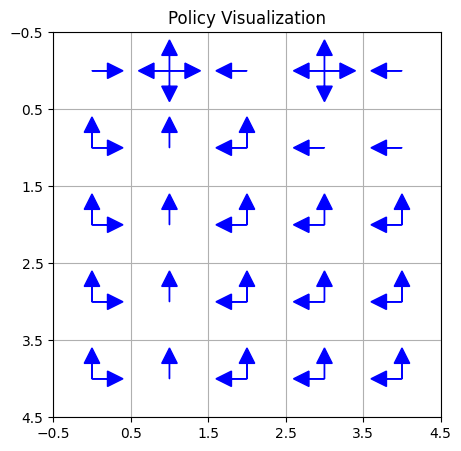

In [57]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_policy(policy):
    """
    Visualizes the policy as arrows on a grid.
    
    Parameters:
    policy (numpy.ndarray): A 3D array where:
        - policy[:,:,0] is the probability for 'North' (↑)
        - policy[:,:,1] is the probability for 'South' (↓)
        - policy[:,:,2] is the probability for 'West' (←)
        - policy[:,:,3] is the probability for 'East' (→)
    """
    n_rows, n_cols, n_dirs = policy.shape
    if n_dirs != 4:
        raise ValueError("Policy must have 4 directions in the third dimension (North, South, West, East).")
    
    # Create a plot
    fig, ax = plt.subplots(figsize=(n_cols, n_rows))
    ax.set_xlim(-0.5, n_cols - 0.5)
    ax.set_ylim(-0.5, n_rows - 0.5)
    ax.set_xticks(np.arange(-0.5, n_cols, 1))
    ax.set_yticks(np.arange(-0.5, n_rows, 1))
    ax.grid(True)
    
    # Arrow parameters
    arrow_params = {
        "head_width": 0.2,
        "head_length": 0.2,
        "length_includes_head": True,
        "color": "blue",
    }
    
    # Iterate over each cell
    for i in range(n_rows):
        for j in range(n_cols):
            # Check each direction
            if policy[i, j, 0] > 0:  # North
                ax.arrow(j, i, 0, -0.4, **arrow_params)
            if policy[i, j, 1] > 0:  # South
                ax.arrow(j, i, 0, 0.4, **arrow_params)
            if policy[i, j, 2] > 0:  # West
                ax.arrow(j, i, -0.4, 0, **arrow_params)
            if policy[i, j, 3] > 0:  # East
                ax.arrow(j, i, 0.4, 0, **arrow_params)
    
    # Reverse the y-axis to align with matrix indexing
    ax.invert_yaxis()
    plt.title("Policy Visualization")
    plt.show()

# Beispiel: Dummy Policy erstellen und visualisieren
example_policy = np.zeros((5, 5, 4))
example_policy[1, 1, 0] = 1  # North at (1, 1)
example_policy[2, 2, 1] = 1  # South at (2, 2)
example_policy[3, 3, 2] = 1  # West at (3, 3)
example_policy[4, 4, 3] = 1  # East at (4, 4)

visualize_policy(current_policy)


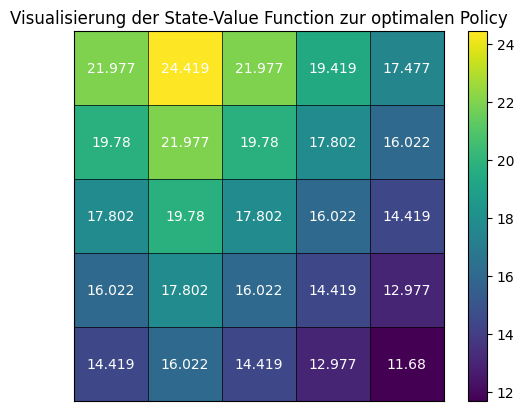

In [62]:
# Beispiel einer 5x5-Matrix
matrix = np.round(current_state_value_end, 3)

# Erstelle die Grafik
fig, ax = plt.subplots()

# Zeige die Matrix als Bild mit Ursprung oben links
cax = ax.imshow(matrix, cmap='viridis', origin='upper')

# Füge Text für jeden Wert in das Raster
for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
        ax.text(j, i, matrix[i, j], ha='center', va='center', color='white')

# Zeige die Farbskala und das Raster
plt.colorbar(cax)
plt.grid(visible=True, color='black', linestyle='-', linewidth=0.5)

# Anpassung der Achsen
ax.set_xticks(np.arange(-0.5, 5, 1))
ax.set_yticks(np.arange(-0.5, 5, 1))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title(f"Visualisierung der State-Value Function zur optimalen Policy")
ax.tick_params(length=0)  # Entfernt die kleinen Ticks auf den Achsen

# Rasterlinien aktivieren
plt.grid(True)
plt.show()


# b)